ModuleNotFoundError: No module named 'vibration_chain'

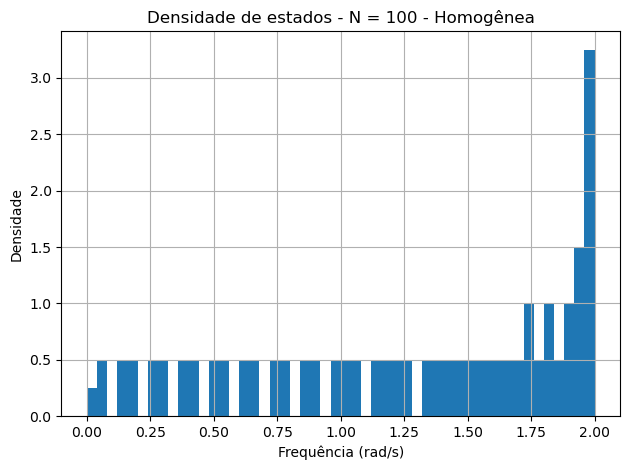

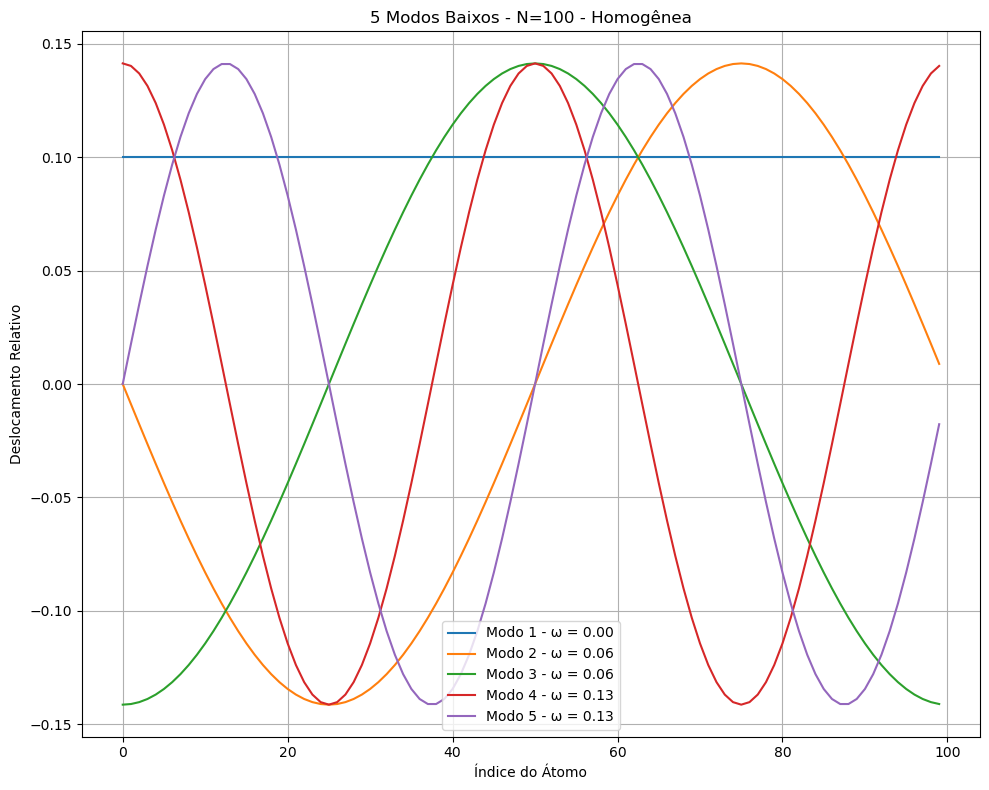

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal

def build_dynamic_matrix(N, m_default=1.0, k=1.0, defect_index=None, defect_mass=None):
    m = np.full(N, m_default)
    if defect_index is not None and defect_mass is not None:
        m[defect_index] = defect_mass

    diagonals = np.full(N, 2 * k / m)
    off_diagonals = np.full(N - 1, -k / np.sqrt(m[1:] * m[:-1]))

    # Periodic boundary condition
    extra_term = -k / np.sqrt(m[0] * m[-1])

    return diagonals, off_diagonals, extra_term

def solve_system(N, m_default=1.0, k=1.0, defect_index=None, defect_mass=None):
    d, e, extra = build_dynamic_matrix(N, m_default, k, defect_index, defect_mass)
    w, v = eigh_tridiagonal(d, e, lapack_driver='stev')
    
    # Add periodic connection correction manually
    if extra != 0:
        D = np.diag(d)
        D += np.diag(e, k=1)
        D += np.diag(e, k=-1)
        D[0, -1] = D[-1, 0] = extra
        w, v = np.linalg.eigh(D)

    frequencies = np.sqrt(np.abs(w))
    return frequencies, v

def plot_histogram(frequencies, N, title):
    plt.figure()
    plt.hist(frequencies, bins=50, density=True)
    plt.title(f'Densidade de estados - N = {N} - {title}')
    plt.xlabel('Frequência (rad/s)')
    plt.ylabel('Densidade')
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'histogram_N{N}_{title}.png')

def plot_modes(modes, N, frequencies, which='low', num_modes=5, title=''):
    plt.figure(figsize=(10, 8))
    indices = np.argsort(frequencies)
    selected = indices[:num_modes] if which == 'low' else indices[-num_modes:]

    for i, idx in enumerate(selected):
        plt.plot(modes[:, idx], label=f'Modo {i+1} - ω = {frequencies[idx]:.2f}')
    plt.title(f'{num_modes} Modos {"Baixos" if which=="low" else "Altos"} - N={N} - {title}')
    plt.xlabel('Índice do Átomo')
    plt.ylabel('Deslocamento Relativo')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'modes_{which}_N{N}_{title}.png')

    from vibration_chain import solve_system, plot_histogram, plot_modes

sizes = [100, 1000, 10000]
k = 1.0
m_default = 1.0
m_defect = 5.0

for N in sizes:
    center = N // 2

    # Homogênea
    freqs_hom, modes_hom = solve_system(N, m_default, k)
    plot_histogram(freqs_hom, N, title="Homogênea")
    plot_modes(modes_hom, N, freqs_hom, which='low', title='Homogênea')
    plot_modes(modes_hom, N, freqs_hom, which='high', title='Homogênea')

    # Com defeito
    freqs_def, modes_def = solve_system(N, m_default, k, defect_index=center, defect_mass=m_defect)
    plot_histogram(freqs_def, N, title="ComDefeito")
    plot_modes(modes_def, N, freqs_def, which='low', title='Com Defeito')
    plot_modes(modes_def, N, freqs_def, which='high', title='Com Defeito')

